In [23]:
%matplotlib inline
import math
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from collections import defaultdict
from scipy.stats import pearsonr
import pandas as pd
from IPython.display import display

# Load calc agg features

In [13]:
DATA_DIR = r"Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data"

DATASETS = {
    "heart_diagnoses_1": "heart_diagnoses_1.csv",
    "laboratory_events_codes_2": "laboratory_events_codes_2.csv",
    "microbiology_events_codes_3": "microbiology_events_codes_3.csv",
    "procedure_code_4": "procedure_code_4.csv",
}

In [14]:
dfs = [pd.read_csv(f"{DATA_DIR}/{DATASETS[dataset].replace('.csv', '_agg_features.csv')}") for dataset in DATASETS.keys()]
len(dfs)

4

In [15]:
for df, name in zip(dfs, DATASETS.keys()):
    print(f"\nDataset: {name}")
    print("="*80)
    print(f"Shape: {df.shape}")
    print("Columns:")
    display(df.head(2))


Dataset: heart_diagnoses_1
Shape: (4864, 9)
Columns:


,subject_id,hadm_id,gender,is_dead,num_imaging_tests,num_unique_icd,note_time_span_hours,hpi_length,has_heartnotes
0,10000980,26913865,F,1,4,1,0.0,1058.0,1
1,10000980,29654838,F,1,3,1,0.0,770.0,1



Dataset: laboratory_events_codes_2
Shape: (4855, 9)
Columns:


,subject_id,hadm_id,num_labs,abnormal_ratio,qc_fail_ratio,lab_time_span_hours,unique_lab_tests,max_glucose,has_labs
0,10000980,26913865.0,166,0.379518,0.024096,140.466667,45,9.0465,1
1,10000980,29654838.0,59,0.423729,0.000000,33.433333,35,7.6590,1



Dataset: microbiology_events_codes_3
Shape: (2756, 7)
Columns:


,subject_id,hadm_id,has_micro,total_microbio_events,unique_specimen_types,unique_organisms,resistant_ratio
0,10000980,26913865,1,1,1,0,0.0
1,10002155,23822395,1,12,4,0,0.0



Dataset: procedure_code_4
Shape: (3459, 6)
Columns:


,subject_id,hadm_id,has_procedure,total_procedures,unique_icd_codes,procedure_span_days
0,10000980,26913865,1,7,7,0.0
1,10002013,24760295,1,2,2,0.0


# Merge

In [16]:
from functools import reduce

# Merge all on ['subject_id', 'hadm_id']
patient_profile = reduce(
    lambda left, right: pd.merge(left, right, on=['subject_id', 'hadm_id'], how='outer'),
    dfs
)

# Fill NaNs for missing features (if some admissions lack labs/micro/proc)
patient_profile.fillna(0, inplace=True)

In [17]:
patient_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subject_id             5166 non-null   int64  
 1   hadm_id                5166 non-null   int64  
 2   gender                 5166 non-null   object 
 3   is_dead                5166 non-null   float64
 4   num_imaging_tests      5166 non-null   float64
 5   num_unique_icd         5166 non-null   float64
 6   note_time_span_hours   5166 non-null   float64
 7   hpi_length             5166 non-null   float64
 8   has_heartnotes         5166 non-null   float64
 9   num_labs               5166 non-null   float64
 10  abnormal_ratio         5166 non-null   float64
 11  qc_fail_ratio          5166 non-null   float64
 12  lab_time_span_hours    5166 non-null   float64
 13  unique_lab_tests       5166 non-null   float64
 14  max_glucose            5166 non-null   float64
 15  has_

In [21]:
patient_profile["gender"].value_counts()

gender
M    2841
F    2017
0     308
Name: count, dtype: int64

In [18]:
patient_profile.head()

,subject_id,hadm_id,gender,is_dead,num_imaging_tests,num_unique_icd,note_time_span_hours,hpi_length,has_heartnotes,num_labs,...,has_labs,has_micro,total_microbio_events,unique_specimen_types,unique_organisms,resistant_ratio,has_procedure,total_procedures,unique_icd_codes,procedure_span_days
0,10000980,26913865,F,1.0,4.0,1.0,0.0,1058.0,1.0,166.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,7.0,7.0,0.0
1,10000980,29654838,F,1.0,3.0,1.0,0.0,770.0,1.0,59.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10002013,24760295,F,0.0,4.0,1.0,0.0,2007.0,1.0,50.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0
3,10002155,23822395,F,0.0,3.0,1.0,0.0,1752.0,1.0,397.0,...,1.0,1.0,12.0,4.0,0.0,0.0,1.0,8.0,8.0,14.0
4,10004457,28723315,M,0.0,3.0,1.0,0.0,1783.0,1.0,25.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
subject_id,hadmid,gender,n_lab_events,n_micro_exam,total_procedures,n_diagnoses,n_positive_micro,n_unique_procedures,abnormal_ratio,max_glucose,mean_creatinine,mean_hemoglobin,age,days_since_last_admission_x,n_total_admissions,days_since_last_admission_y


In [25]:
patient_profile.columns

Index(['subject_id', 'hadm_id', 'gender', 'is_dead', 'num_imaging_tests',
       'num_unique_icd', 'note_time_span_hours', 'hpi_length',
       'has_heartnotes', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio',
       'lab_time_span_hours', 'unique_lab_tests', 'max_glucose', 'has_labs',
       'has_micro', 'total_microbio_events', 'unique_specimen_types',
       'unique_organisms', 'resistant_ratio', 'has_procedure',
       'total_procedures', 'unique_icd_codes', 'procedure_span_days'],
      dtype='object')

# Completeness matrix

In [26]:
# Identify the 'has_' indicator columns
has_columns = [col for col in patient_profile.columns if col.startswith('has_')]
print(f"Data source indicators: {has_columns}")

# Create completeness summary

Data source indicators: ['has_heartnotes', 'has_labs', 'has_micro', 'has_procedure']



COMPLETENESS SUMMARY

Per-Source Availability:
  has_heartnotes: 4,864 patients (94.2%)
  has_labs: 4,855 patients (94.0%)
  has_micro: 2,756 patients (53.3%)
  has_procedure: 3,459 patients (67.0%)

--------------------------------------------------------------------------------
DATA SOURCE COMBINATIONS:
--------------------------------------------------------------------------------
  [1-1-1-1] heartnotes, labs, micro, procedure: 1,932 (37.4%)
  [1-1-0-1] heartnotes, labs, procedure: 1,525 (29.5%)
  [1-1-0-0] heartnotes, labs: 876 (17.0%)
  [1-1-1-0] heartnotes, labs, micro: 522 (10.1%)
  [0-0-1-0] micro: 302 (5.8%)
  [1-0-0-0] heartnotes: 7 (0.1%)
  [1-0-0-1] heartnotes, procedure: 2 (0.0%)


C:\Users\dgars\AppData\Local\Temp\ipykernel_11776\2020775151.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(sources, rotation=45, ha='right')


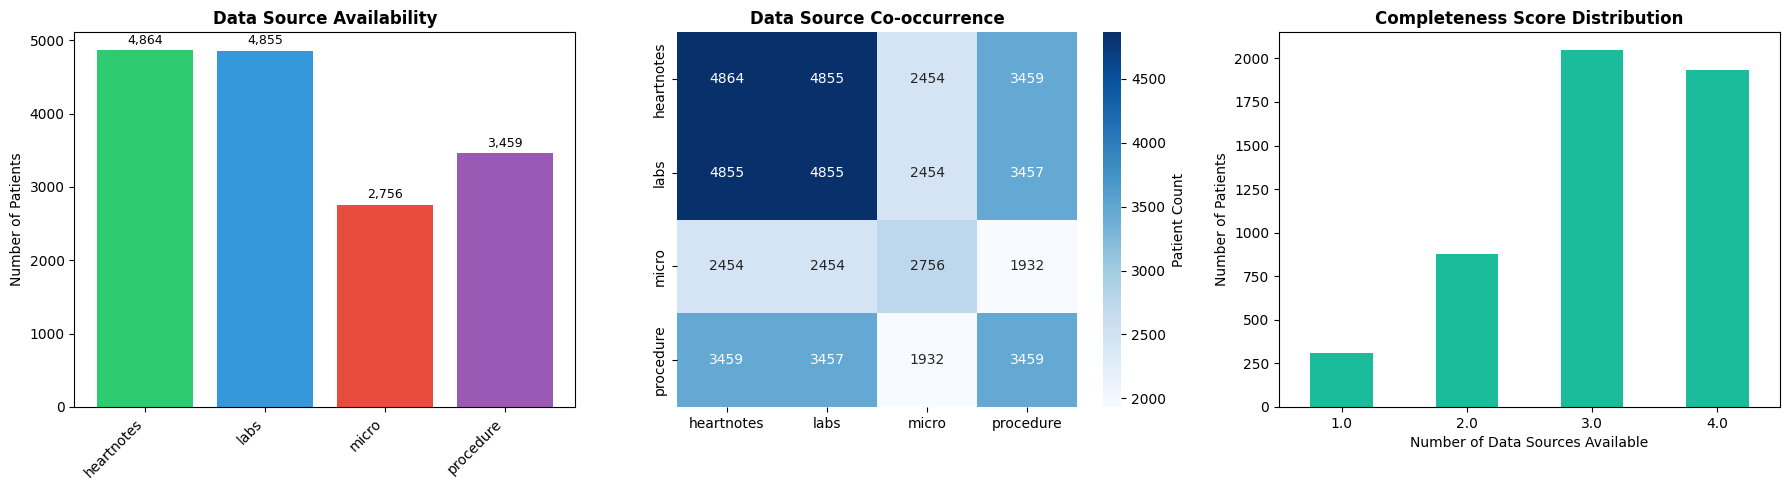


COMPLETENESS SCORE SUMMARY

Total patients: 5,166
Patients with ALL sources: 1,932
Patients with NO sources: 0
Average sources per patient: 3.08


In [27]:
# Completeness Matrix - Check which data sources are available for each patient


completeness = patient_profile[has_columns].copy()

# Summary statistics
print("\n" + "="*80)
print("COMPLETENESS SUMMARY")
print("="*80)

# Per-source completeness
print("\nPer-Source Availability:")
for col in has_columns:
    count = (patient_profile[col] == 1).sum()
    pct = count / len(patient_profile) * 100
    print(f"  {col}: {count:,} patients ({pct:.1f}%)")

# Combination completeness
print("\n" + "-"*80)
print("DATA SOURCE COMBINATIONS:")
print("-"*80)

# Create a combined key for each row
completeness['combination'] = completeness[has_columns].astype(int).astype(str).agg('-'.join, axis=1)
combo_counts = completeness['combination'].value_counts()

# Create readable labels
for combo, count in combo_counts.items():
    sources = [has_columns[i].replace('has_', '') for i, val in enumerate(combo.split('-')) if val == '1']
    sources_str = ', '.join(sources) if sources else 'None'
    pct = count / len(patient_profile) * 100
    print(f"  [{combo}] {sources_str}: {count:,} ({pct:.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Bar chart of individual source availability
ax1 = axes[0]
source_counts = [(col.replace('has_', ''), (patient_profile[col] == 1).sum()) for col in has_columns]
sources, counts = zip(*source_counts)
bars = ax1.bar(sources, counts, color=['#2ecc71', '#3498db', '#e74c3c', '#9b59b6'][:len(has_columns)])
ax1.set_ylabel('Number of Patients')
ax1.set_title('Data Source Availability', fontweight='bold')
ax1.set_xticklabels(sources, rotation=45, ha='right')
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count:,}', ha='center', va='bottom', fontsize=9)

# Plot 2: Heatmap of co-occurrence
ax2 = axes[1]
cooccurrence = pd.DataFrame(index=has_columns, columns=has_columns, dtype=float)
for col1 in has_columns:
    for col2 in has_columns:
        both = ((patient_profile[col1] == 1) & (patient_profile[col2] == 1)).sum()
        cooccurrence.loc[col1, col2] = both

# Rename for display
cooccurrence.index = [c.replace('has_', '') for c in cooccurrence.index]
cooccurrence.columns = [c.replace('has_', '') for c in cooccurrence.columns]

sns.heatmap(cooccurrence.astype(float), annot=True, fmt='.0f', cmap='Blues', 
            ax=ax2, cbar_kws={'label': 'Patient Count'})
ax2.set_title('Data Source Co-occurrence', fontweight='bold')

# Plot 3: Completeness score distribution
ax3 = axes[2]
patient_profile['completeness_score'] = patient_profile[has_columns].sum(axis=1)
patient_profile['completeness_score'].value_counts().sort_index().plot(kind='bar', ax=ax3, color='#1abc9c')
ax3.set_xlabel('Number of Data Sources Available')
ax3.set_ylabel('Number of Patients')
ax3.set_title('Completeness Score Distribution', fontweight='bold')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(r'../plots/1.2_completeness_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Final summary
print("\n" + "="*80)
print("COMPLETENESS SCORE SUMMARY")
print("="*80)
print(f"\nTotal patients: {len(patient_profile):,}")
print(f"Patients with ALL sources: {(patient_profile['completeness_score'] == len(has_columns)).sum():,}")
print(f"Patients with NO sources: {(patient_profile['completeness_score'] == 0).sum():,}")
print(f"Average sources per patient: {patient_profile['completeness_score'].mean():.2f}")

# Corr

# Analyse (DU of patient profile)

# Save to csv

In [24]:
patient_profile.to_csv(os.path.join(DATA_DIR, "patient_profile_final.csv"), index=False)